##### This notebook was set up by Erica Sturm. Send your questions and comments to esturm@bnl.gov.
##### Ejs recommends DOI 10.1145/3205289.3205290  at https://dl.acm.org/doi/10.1145/3205289.3205290 by You, Y. et al for guiding principals.

## Load relevant libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
complete_path = os.getcwd()
if 'nb' in complete_path:
    os.chdir("..")

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import os
import pandas as pd
import yaml
from IPython.display import clear_output
import warnings

In [4]:
from sklearn.kernel_ridge import KernelRidge
import time
from mlnrg.utils.logger import log

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from mlnrg.utils.mpl_at_utils import MPLAdjutant
from mlnrg.loader import NRGData

## Choose data sets

In [6]:
#kondo = pd.read_csv('data/Kondo_411267_trials_with_headers.csv')
#anderson = pd.read_csv('data/Anderson_599578_trials_with_headers.csv')
#grid = 'pd.read_csv(data/Omega_grid_values.csv')
data_set = pd.read_csv('data/Anderson_599578_trials_with_headers.csv')

In [7]:
#fps_indexes = pickle.load(open("results/fps_files/anderson_fps.pkl", "rb"))
#rps_indexes = pickle.load(open("results/fps_files/kondo_fps.pkl", "rb"))
point_indexes = pickle.load(open("results/fps_files/anderson_fps.pkl", "rb"))

#### Choose either furthest point sampling (FPS) or random point sampling (RPS) to train and test with. It is important to use these (without shfffling) so that the trials in the training/validation/test sets are the same as those in the NN!

In [8]:
all_training_idx = list(point_indexes[0]['train'])
all_validation_idx = list(point_indexes[0]['valid'])


#### Specify number of trials to be used in training. Default is 50K!

In [9]:
total_trials = 50000 # Default is 50000
unscaled_tr_features = (data_set.loc[all_training_idx[:],'U':'T']).to_numpy()
tr_targets = (data_set.iloc[all_training_idx[:], 8:]).to_numpy()
all_starting_trials = len(unscaled_tr_features)

unscaled_val_features = (data_set.loc[all_validation_idx,'U':'T']).to_numpy()
val_targets = (data_set.iloc[all_validation_idx, 8:]).to_numpy()

################################################################################################
# Default = 10; try to have subset sizes be 50K trials or fewer!!!!
number_subsets = 12
################################################################################################
remainder_trials = len(unscaled_tr_features) % number_subsets
log.info("\nTo attain the desired number of subsets, %d trials had to be removed from training." 
         % remainder_trials
        )

if (remainder_trials >= len(unscaled_tr_features)*0.001):
    log.warn("The number of subsets requested will require the removal of %d, "\
             "more than 1/1000 of the available training data." 
            )
if (remainder_trials != 0):    
    unscaled_tr_features = unscaled_tr_features[:-1*remainder_trials]
    tr_targets = tr_targets[:-1*remainder_trials]
    
subset_size = len(unscaled_tr_features)/number_subsets # (Will be 5K if using all default values.)

log.info("\nOriginal number of training trials:\t%d\nRemaining number of training trials:\t%d"\
        "\nRemoved trials:\t\t%d (%.5g%% of the total trials)\nNumber of subsets:\t%d\n"\
        "Trials per subset:\t%6.1f"
         % (all_starting_trials, len(unscaled_tr_features), remainder_trials, 
            (100*remainder_trials/all_starting_trials), number_subsets, subset_size) 
        )

subset_size = int(subset_size)

2020-09-24 16:46:39,213 INFO    [<ipython-input-9-9f82060a93ab>:15] 
To attain the desired number of subsets, 10 trials had to be removed from training.
2020-09-24 16:46:39,224 INFO    [<ipython-input-9-9f82060a93ab>:32] 
Original number of training trials:	575578
Remaining number of training trials:	575568
Removed trials:		10 (0.0017374% of the total trials)
Number of subsets:	12
Trials per subset:	47964.0


#### Do symlog scaling if desired. Comment or uncomment as desired.

In [10]:
# # Start with B: rescale with symlog after adjusting for B=0 cases.
# m = (data_set[data_set['B'] != 0]['B']).abs().min()
# data_set.loc[list((data_set[data_set['B'] == 0]).index), 'B'] = m/10

# sign_B = np.sign(data_set['B'])
# data_set.loc[:, 'B'] = sign_B * np.log10(np.abs(data_set.loc[:, 'B']))
# #data_set.rename(columns={'B': 'symlog10 B'}, inplace=True)


# # Now do T: rescale with regular log after adjusting for T=0 cases.
# m = (data_set[data_set['T'] != 0]['T']).abs().min()
# data_set.loc[list((data_set[data_set['T'] == 0]).index), 'T'] = m/10
# data_set.loc[:, 'T'] = np.log10(data_set.loc[:, 'T'])
# #data_set.rename(columns={'T': 'log10 T'}, inplace=True)

# # Now do Gamma: recale with regular log.
# data_set.loc[:, 'Gamma'] = np.log10(data_set.loc[:, 'Gamma'])
# #data_set.rename(columns={'Gamma': 'log10 Gamma'}, inplace=True)

#### Feature scaling.

In [11]:
mu_scaling = unscaled_tr_features.mean(axis=0)
std_scaling = unscaled_tr_features.std(axis=0)

tr_features = (unscaled_tr_features - mu_scaling) / std_scaling
val_features = (unscaled_val_features - mu_scaling) / std_scaling


unscaled_val_mean = np.mean(unscaled_val_features.mean(axis=0))
unscaled_val_std = np.mean(unscaled_val_features.std(axis=0))

rescaled_tr_mean = np.mean(tr_features.mean(axis=0))
rescaled_tr_std = np.mean(tr_features.std(axis=0))
rescaled_val_mean = np.mean(val_features.mean(axis=0))
rescaled_val_std = np.mean(val_features.std(axis=0))

log.info("\nThe original mean +/- std of the training features: %.4f +/- %.4f.\n" \
         "The rescaled mean +/- std of the training features: %.4f +/- %.4f.\n\n" \
         "The original mean +/- std of the validation features: %.4f +/- %.4f.\n" \
         "The rescaled mean +/- std of the validation features: %.4f +/- %.4f."
         % (np.mean(mu_scaling), np.mean(std_scaling), 
           rescaled_tr_mean, rescaled_tr_std,
           unscaled_val_mean, unscaled_val_std,
           rescaled_val_mean, rescaled_val_std
           )
        )

2020-09-24 16:46:39,333 INFO    [<ipython-input-11-cad79882db0b>:23] 
The original mean +/- std of the training features: 0.0184 +/- 0.0517.
The rescaled mean +/- std of the training features: 0.0000 +/- 1.0000.

The original mean +/- std of the validation features: 0.0184 +/- 0.0520.
The rescaled mean +/- std of the validation features: -0.0006 +/- 1.0010.


## Set up machine learning architecture, train, run validation.

#### Set up all hyperparameters and initialize KRR model: choose values for "gamma" the kernel radius and "alpha" the regularization term. The kernel is a constant set to "Laplacian": $k(x,y) = \mathrm{exp}(-\gamma||x-y||_1)$. The "number_subsets" is the number of mini-training-sets that will each have a KRR fitted to them prior to averaging for the final result. A larger number of subsets (and thus fewer training trials per subset) increases error in the final result!

#### The defaults are number_subsets = 10, gamma=0.1 and alpha=0 (the same as Arsenault's values). Note that in the literature the kernel radius is denoted $\frac{1}{\sigma}$ and the regularization term is $\lambda$. 

In [12]:
alpha = 0 # Default = 0.0
gamma = 0.01 # Default = 0.1

all_subset_features = np.array_split(tr_features, number_subsets) 
all_subset_targets = np.array_split(tr_targets, number_subsets)

for ii in range(number_subsets):
    log.info("Subset %d has %d trials." % (ii, len(all_subset_features[ii])))

# Set up model
krr_Model = KernelRidge(kernel='laplacian', gamma=gamma, alpha=alpha)

2020-09-24 16:46:39,368 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 0 has 47964 trials.
2020-09-24 16:46:39,368 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 1 has 47964 trials.
2020-09-24 16:46:39,369 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 2 has 47964 trials.
2020-09-24 16:46:39,369 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 3 has 47964 trials.
2020-09-24 16:46:39,370 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 4 has 47964 trials.
2020-09-24 16:46:39,370 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 5 has 47964 trials.
2020-09-24 16:46:39,371 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 6 has 47964 trials.
2020-09-24 16:46:39,371 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 7 has 47964 trials.
2020-09-24 16:46:39,372 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 8 has 47964 trials.
2020-09-24 16:46:39,372 INFO    [<ipython-input-12-4a5b9b0c0944>:8] Subset 9 has 47964 trials.
2020-09-24 16:46:39,373 INFO    [<ipython-input-12

#### Set up a bunch of empty arrays to organize all the palaver that is going to happen during training. The comments should explain what each is for. (As of this writing (2020-09-04) not all are used, but I have plans...-Ejs)

In [13]:
# These are going to be used below for the user query subroutine according to this eqn: (K(train))

# These two store EACH SUBSET's features/targets in a single row. 
# Eg for subset 0, subset_feature[0] == all features from that subset's trials in one single long row.
# If the user wants to query the model for a new trial (like the whole test set), these values are necessary.
subset_features = np.empty([number_subsets, tr_features.shape[1]*subset_size])
subset_targets = np.empty([number_subsets, tr_targets.shape[1]*subset_size])

# The weights of each subset's trained model. In the literature this is often called 'alpha' but 
# in Scikit that word 'alpha' is the regularization term. 
alpha_weights = np.empty([number_subsets, subset_size*tr_targets.shape[1]]) 

# The error of each subset's model. The first column is that of the training data and should be nearly 1.0.
# The second column is that of the validation set.
iter_costs = np.empty([number_subsets, 2])

# Sum of all predictions for the final combined model.
sum_predictions = np.zeros([1, tr_targets.shape[1]]) 


#### This cell exists so that the user may pick up where they left off; at the end of each iteration of the below for-loop a checkpoint file is saved locally. Should the job die in the middle, the user would run this cell to re-initialize the experiment and pick up where it left off. All previous completed trials will be stored, so if it died in the middle of itreation N, then the stored info is up to and including N-1. 

In [14]:
load_from_checkpoint = True

if (load_from_checkpoint == True):
    # MODIFY THE FILE NAME IN THE LINE BELOW TO LOAD FROM A CHECKPOINT!
    ckpt_name = open('results/DC-KRR/checkpoints/CKPT_anderson_fps_alpha0_gamma0.01.pkl', 'rb')
    
    ckpt_data = pickle.load(ckpt_name)
    
    # Reset all job details to pick up where we left off.....
    all_subset_features = ckpt_data["all_subset_features"]
    all_subset_targets = ckpt_data["all_subset_targets"]
    subset_features = ckpt_data["subset_features"]
    subset_targets = ckpt_data["subset_targets"]
    number_subsets = ckpt_data["number_subsets"]
    subset_size = ckpt_data["trials_per_set"]
    alpha = ckpt_data["alpha"]
    gamma = ckpt_data["gamma"]
    iter_costs = ckpt_data["iter_costs"]
    alpha_weights = ckpt_data["alpha_weights"]
    sum_predictions = ckpt_data["sum_predictions"]
    
    # Remind the user what we were up to when things died. 
    print("Reloading from a checkpoint with these values: ")
    print("%s set with %s sampling\n%d subsets, %d trials per subset" 
          % (ckpt_data["set"], ckpt_data["sampling"], number_subsets, subset_size)
         )
    print("Parameters: alpha = %1.5g and gamma = %1.5g" % (alpha, gamma))
    print("Finished subset %d, (started at 0); start at %d+1=%d" 
          % (ckpt_data["finished_iteration"], ckpt_data["finished_iteration"], ckpt_data["finished_iteration"]+1)
         )

Reloading from a checkpoint with these values: 
kondo set with fps sampling
12 subsets, 47964 trials per subset
Parameters: alpha = 0 and gamma = 0.01
Finished subset 10, (started at 0); start at 10+1=11


#### Run DC-KRR. In each iteration a single subset of training data is fit and the validation set is tested against that "mini-model." At the end all results are averaged for a final result.

#### This is a very complicated algorithm because the Scikit library does not have a native subroutine DC-KRR. The comments should guide you through each step. Ejs recommends DOI 10.1145/3205289.3205290  at https://dl.acm.org/doi/10.1145/3205289.3205290 by You, Y. et al for a crash-course on how to think about this method's family. 

In [15]:
time_start = time.time()

if (load_from_checkpoint == True):
    start_iter = ckpt_data["finished_iteration"]+1
    print("************************************************\n" \
          "****** Restarting from a previous save!!! ******\n"\
          "************************************************\n"
         )
else:
    start_iter = 0
    
for s in range(start_iter, number_subsets):
    print("Starting iteration s=%d/%d" % (s+1, number_subsets))
    t0 = time.time()
    iter_features = all_subset_features[s]
    iter_targets = all_subset_targets[s]

    # Each row represents all featuer/target info for all trials in that subset!
    subset_features[s] = iter_features.flatten()
    subset_targets[s] = iter_targets.flatten()  

    # Fit each training subset. Compute cost too.
    iter_model = krr_Model.fit(iter_features, iter_targets)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        iter_tr_cost = iter_model.score(iter_features, iter_targets)
        
    # The subset's kernel weights.     
    alpha_weights[s] = iter_model.dual_coef_.flatten()
    
    #--------------------------------------------------------------------
    # NOW RUN THE VALIDATION SET AGAINST EACH SUBSET'S TRAINED KRR MODEL. 
    #--------------------------------------------------------------------
    
    # Compute the (Laplacian) kernel of the validation features 
    # and this training subset's features.
    kernel_of_val_and_tr = pairwise_kernels(val_features, iter_features, 
                                            metric='laplacian', 
                                            gamma=gamma, 
                                            alpha=alpha, 
                                            filter_params=True
                                           )
    
    # Compute the dot product of the kernel and model's weights.
    iter_prediction = np.dot(kernel_of_val_and_tr, iter_model.dual_coef_)

    # Compute cost of the model when the validation set is used. 
    u_value = ((val_targets - iter_prediction)**2).sum()
    v_value = ((val_targets - val_targets.mean())**2).sum()
    iter_val_cost = 1 - (u_value/v_value)
    
    # Store the model's own mini-training set cost and the validation set cost. 
    iter_costs[s,0] = iter_tr_cost
    iter_costs[s,1] = iter_val_cost
        
    # Keep running sum of each iteration's validation set results.
    # This is going to be used after all mini-training sets are done. See below.
    sum_predictions = np.add(sum_predictions, iter_prediction)
    
    iter_time = time.time() - t0
    
    print("Iteration complte in: %.3g seconds\nTraining Cost = %.5g\nValidation Cost = %.5g\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~" 
          % (iter_time, iter_tr_cost, iter_val_cost)
         )
    
    # Save current progress at the end of the for-loop as a checkpoint because my computer is being a dweeb.
    dckrr_ckpt = {
        "set": "kondo",
        "sampling": "fps",
        "tr_set_size": len(tr_features),
        "number_subsets": number_subsets,
        "trials_per_set": subset_size,
        "finished_iteration": s,
        "all_subset_features": all_subset_features,
        "all_subset_targets": all_subset_targets,
        "subset_features": subset_features,
        "subset_targets": subset_targets,
        "alpha": alpha,
        "gamma": gamma,
        "iter_costs": iter_costs,
        "alpha_weights": alpha_weights,
        "sum_predictions": sum_predictions
        }
    pickle.dump(dckrr_ckpt, 
                open("results/DC-KRR/checkpoints/CKPT_anderson_fps_alpha0_gamma0.01.pkl", "wb" )
               )


************************************************
****** Restarting from a previous save!!! ******
************************************************

Starting iteration s=12/12
Iteration complte in: 713 seconds
Training Cost = 1
Validation Cost = 0.74964
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [16]:
#--------------------------------
# THIS IS THE FINAL PREDICTION!!!
#--------------------------------
averaged_predictions = sum_predictions / number_subsets

fit_time = time.time() - time_start
log.info("\nAll %d/%d subsets with %d trials/subset trained and averaged. Total time: %.3g seconds" 
% (s+1, number_subsets, subset_size, fit_time)
        )    

2020-09-24 16:58:54,113 INFO    [<ipython-input-16-d4e4c01b6672>:8] 
All 12/12 subsets with 47964 trials/subset trained and averaged. Total time: 731 seconds


#### Compute and sort errors. 

In [17]:
errors = np.mean(np.abs(val_targets - averaged_predictions), axis=1)
sorted_errors = []
for ii in range(len(errors)):
  sorted_errors.append([ii, val_targets[ii], averaged_predictions[ii], errors[ii]])

sorted_errors.sort(key=lambda x: x[3])

## Plot Results

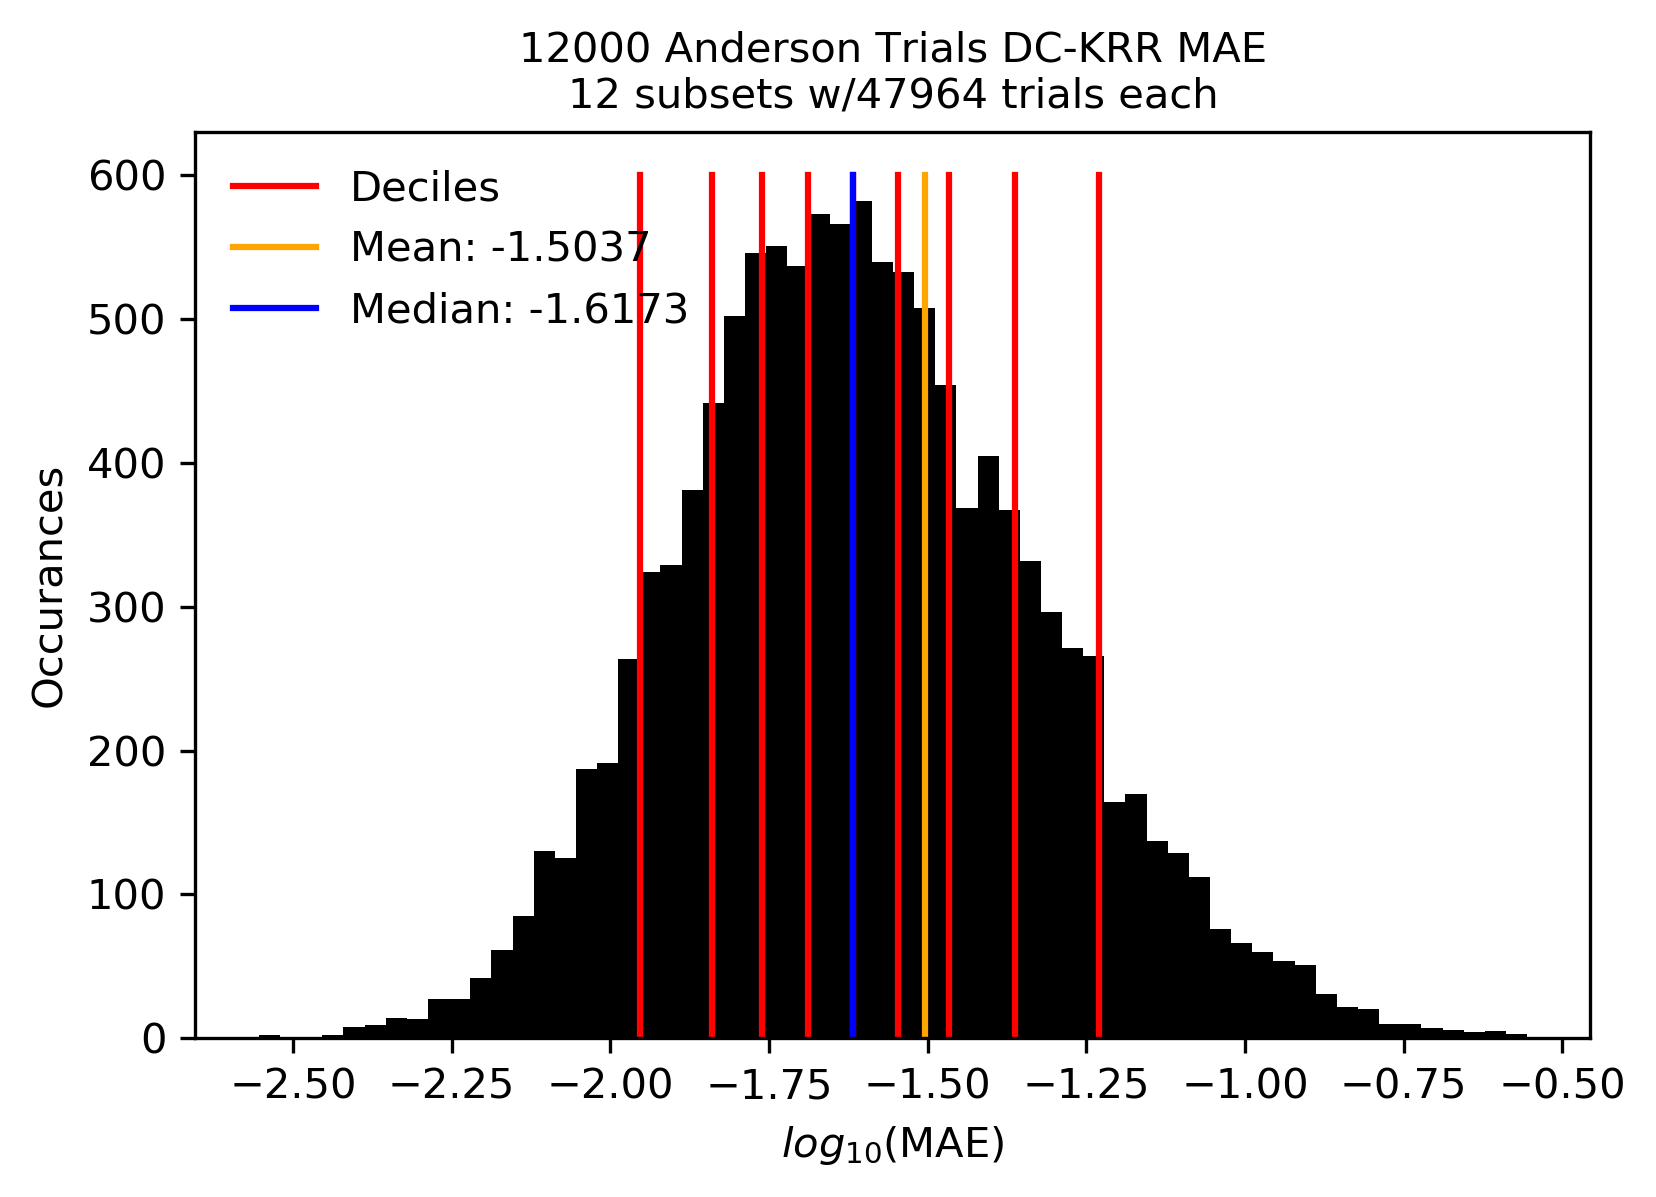

In [18]:
plt.clf()
#krr_err_hist_name='hist' + save_Name + '.png'

y_Height = 0.05 * len(errors)
mean = np.log10(np.mean(errors))
median = np.log10(np.median(errors))

plt.hist(np.log10(errors), bins=60, color='k')
for ii in range(1, 10):
    x = np.log10(np.percentile(errors, ii*10))
    plt.plot((x, x), (0, y_Height), color='r', label="Deciles" if ii == 1 else None)
plt.plot((mean, mean), (0, y_Height), color='orange', label=f"Mean: {mean:.05g}")
plt.plot((median, median), (0, y_Height), color='b', label=f"Median: {median:.05g}")

plt.title("%d Anderson Trials DC-KRR MAE\n%d subsets w/%d trials each" % 
          (len(errors), number_subsets, subset_size),
          fontsize=10
         )
plt.xlabel("$log_{10}(\mathrm{MAE})$")
plt.ylabel("Occurances")
plt.legend(loc="upper left", frameon=False)

#plt.savefig(krr_err_hist_name, dpi=300, bbox_inches='tight')
plt.show()

## Save relevant information

In [19]:
dckrr_info = {
    "set": "anderson",
    "sampling": "fps",
    "alpha": alpha,
    "gamma": gamma,
    "tr_set_size": len(tr_features),
    "number_subsets": number_subsets,
    "val_set_size": len(val_features),
    "trained_weights": alpha_weights,
    "fit_time": fit_time,
    "sorted_errors": sorted_errors,
    "costs": iter_costs
}

### MODIFY THIS CELL TO ENSURE YOU DO NOT OVERWRITE A PREVIOUS SAVE. 

In [20]:
pickle.dump(dckrr_info, open("results/DC-KRR/anderson_full_alpha0_gamma0.01_subsets12.pkl", "wb" ))